# BERT Model on Combined Text.

In this section, we are applying **BERT (Bidirectional Encoder Representations from Transformers)** to predict whether a given news article is *fake* or *true*.  

### Why BERT?
- BERT is a **transformer-based model** that has been pre-trained on massive amounts of text.  
- It understands **context in both directions** (left and right of a word), which makes it powerful for language understanding tasks.  
- For text classification tasks like **fake news detection**, BERT has shown state-of-the-art performance compared to traditional machine learning methods.  

### Workflow
We will follow these steps in our modeling pipeline:

1. **Install dependencies** – Set up HuggingFace Transformers, PyTorch, and Scikit-learn.  
2. **Load data** – Import the prepared train, validation, and test CSVs.  
3. **Explore data** – Check dataset shape, column names, and class balance.  
4. **Preprocess & tokenize** – Convert raw text into tokens using the bert-base-uncased tokenizer.  
5. **Create PyTorch dataset loaders** – Wrap the tokenized inputs and labels into PyTorch Dataset and DataLoader objects for training.  
6. **Model setup** – Load BertForSequenceClassification with two labels (fake vs true).  
7. **Training loop** – Train BERT with AdamW optimizer, scheduler, and backpropagation.  
8. **Evaluation** – Measure accuracy, precision, recall, and F1 score on validation and test data.  
9. **Save the model** – Store the trained model and tokenizer for future use.

By the end of this workflow, we will have a fine-tuned BERT model that can classify unseen news articles as either fake or true.


## Step 1: Installing dependencies.

In [2]:
!pip install transformers datasets torch scikit-learn -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.9 MB/s eta 0:00:00
ERROR: pip's dependency 

In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm


2025-10-01 05:39:06.424872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759297146.596927      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759297146.647550      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Step 2: Loading data.

We now load the training, validation, and test datasets

- train.csv: Used for fitting the BERT model parameters.
- val.csv: Used during training to monitor model performance and tune hyperparameters.
- test.csv: Held out until the final stage to evaluate the model on completely unseen data.

In [4]:
# Load the prepared datasets
train_df = pd.read_csv("/kaggle/input/modelling-data/Modelling Data/train.csv")
val_df   = pd.read_csv("/kaggle/input/modelling-data/Modelling Data/val.csv")
test_df  = pd.read_csv("/kaggle/input/modelling-data/Modelling Data/test.csv")

# Check dataset shapes
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

# Glimpse of training data
train_df.head()


Train shape: (35918, 10)
Validation shape: (4490, 10)
Test shape: (4490, 10)


,title,text,subject,date,label,title_clean,text_clean,combined_text,_char_len,_tok_len_ws
0,UPDATE: BUSTED By The Secret Service…CNN’s Apr...,The Secret Service pushed back on a CNN report...,left-news,"Dec 13, 2017",FAKE,update busted secret service cnn april ryan ca...,secret service pushed back cnn reporter claim ...,update busted secret service cnn april ryan ca...,1260,180
1,THE LEFT LOSES AGAIN: Third Quarter Economic E...,The news that the forecast for the third quart...,Government News,"Aug 19, 2017",FAKE,left loses third quarter economic estimate exp...,news forecast third quarter gdp set expand bad...,left loses third quarter economic estimate exp...,1166,162
2,"Trump’s Own Staff Thinks He’s A Joke, Laughs ...",As the Russian investigation is getting uncomf...,News,"June 12, 2017",FAKE,trump staff think joke laugh july th ultimatum,russian investigation getting uncomfortably cl...,trump staff think joke laugh july th ultimatum...,1587,227
3,Seoul considers unilateral sanctions against N...,SEOUL (Reuters) - South Korea is considering l...,worldnews,"October 18, 2017",TRUE,seoul considers unilateral sanction north korea,seoul reuters south korea considering levying ...,seoul considers unilateral sanction north kore...,390,55
4,Democrats Offer Bill That Would FORCE Trump T...,The vast majority of Donald Trump s campaign p...,News,"March 24, 2017",FAKE,democrat offer bill would force trump keep one...,vast majority donald trump campaign promise un...,democrat offer bill would force trump keep one...,1962,266


# Step 3: Explore the Data.

In [5]:
# Check unique labels
print("Unique labels:", train_df['label'].unique())

# Convert labels to numeric (FAKE=0, TRUE=1)
label_mapping = {"FAKE": 0, "TRUE": 1}
train_df['label_num'] = train_df['label'].map(label_mapping)
val_df['label_num']   = val_df['label'].map(label_mapping)
test_df['label_num']  = test_df['label'].map(label_mapping)

# Check distribution of classes
print("Training label distribution:\n", train_df['label_num'].value_counts(normalize=True))
print("Validation label distribution:\n", val_df['label_num'].value_counts(normalize=True))
print("Test label distribution:\n", test_df['label_num'].value_counts(normalize=True))

# sneak peek after conversion
train_df[['combined_text', 'label', 'label_num']].head()


Unique labels: ['FAKE' 'TRUE']
Training label distribution:
 label_num
0    0.522997
1    0.477003
Name: proportion, dtype: float64
Validation label distribution:
 label_num
0    0.52294
1    0.47706
Name: proportion, dtype: float64
Test label distribution:
 label_num
0    0.52294
1    0.47706
Name: proportion, dtype: float64


,combined_text,label,label_num
0,update busted secret service cnn april ryan ca...,FAKE,0
1,left loses third quarter economic estimate exp...,FAKE,0
2,trump staff think joke laugh july th ultimatum...,FAKE,0
3,seoul considers unilateral sanction north kore...,TRUE,1
4,democrat offer bill would force trump keep one...,FAKE,0


# Step 4: Define Parameters.

### Setting Parameters

At this stage, after inspecting the dataset, we define all key parameters in one dictionary (PARAMS):

  **model_name**: the pre-trained model to load (bert-base-uncased is common for English).  
  **max_len**: maximum token length for each sequence. This controls how long inputs are padded/truncated during tokenization.  
  **batch_size**: number of samples per batch for training.  
  **learning_rate**: optimizer learning rate (2e-5 is a typical starting point for BERT).  
  **epochs**: how many times we train over the full dataset.  
  **device**: whether to run on GPU (cuda) or CPU.

Defining these here ensures that tokenization, dataloaders, and model training are consistent and reproducible.


In [6]:
# Defining all important parameters in one place
PARAMS = {
    "model_name": "bert-base-uncased",   # pre-trained BERT model
    "max_len": 256,                      # max token length for each input
    "batch_size": 16,                    # batch size for DataLoader
    "learning_rate": 2e-5,               # learning rate for AdamW optimizer
    "epochs": 3,                         # number of training epochs
    "device": "cuda" if torch.cuda.is_available() else "cpu"  # use GPU if available
}


PARAMS


{'model_name': 'bert-base-uncased',
 'max_len': 256,
 'batch_size': 16,
 'learning_rate': 2e-05,
 'epochs': 3,
 'device': 'cuda'}

# Step 5: Tokenization.

In [7]:
from transformers import BertTokenizer

# Load the tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained(PARAMS["model_name"])

# sanity check;tokenize a single sentence
sample_text = train_df["combined_text"].iloc[0]
tokens = tokenizer.encode_plus(
    sample_text,
    max_length=PARAMS["max_len"],
    padding="max_length",
    truncation=True,
    return_tensors="pt"   # return PyTorch tensors
)

print("Original text:\n", sample_text[:200], "...\n")  # first 200 chars
print("Token IDs:\n", tokens["input_ids"])
print("Attention mask:\n", tokens["attention_mask"])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Original text:
 update busted secret service cnn april ryan called fake report trump aide firing video secret service pushed back cnn reporter claim fired trump aide physically removed white house reporting regarding ...

Token IDs:
 tensor([[  101, 10651, 23142,  3595,  2326, 13229,  2258,  4575,  2170,  8275,
          3189,  8398, 14895,  7493,  2678,  3595,  2326,  3724,  2067, 13229,
          6398,  4366,  5045,  8398, 14895,  8186,  3718,  2317,  2160,  7316,
          4953,  3595,  2326,  5073,  8186,  9268, 13192,  8820, 23624, 20420,
          7096, 10625,  2317,  4580,  3375, 16542,  1057,  3595,  2326,  7800,
          2121,  7903,  2063,  2285,  3041,  2651, 13229,  2258,  4575,  2988,
          8398,  3447, 14895, 13192,  8820, 23624, 20420,  7096, 13127,  2317,
          2160,  3595,  2326,  2961,  5045,  2708,  3095,  2198,  5163,  2137,
          3923,  2557,  2897,  2317,  2160, 11370,  2258,  4575,  2409,  2466,
         14895,  7493, 13229,  2258, 21190,  2319,  318

## When we tokenized a sample, we got two main results:

 **Input IDs**: Each word or subword is mapped to a numeric ID from BERT’s vocabulary.  
    The sequence starts with [CLS] (ID 101) and ends with [SEP] (ID 102).  
    If the text is shorter than 256 tokens, the rest is padded with 0s.  
    If longer, it is truncated to 256 tokens.  

 **Attention Mask**: A sequence of 1s and 0s.  
    1 means a real token.  
    0 means a padding token.  

This ensures that all inputs have the same length (max_len=256), and BERT can ignore padding during training.


## Step 6:  Create Pytorch dataset loaders

To prepare the data for BERT, we wrap it in a **custom PyTorch Dataset**:

 **NewsDataset**:  
   Takes the cleaned text (combined_text) and labels.  
   Uses the BERT tokenizer with our chosen `max_len=256`.  
   Returns `input_ids`, `attention_mask`, and `labels` tensors for each sample.  

We then create **DataLoaders** for train, validation, and test sets:  
 These efficiently batch and shuffle the data.  
 Each batch contains:
   input_ids → tokenized text  
   attention_mask → marks real tokens vs. padding  
   labels → 0 (FAKE) or 1 (TRUE)  

These DataLoaders will feed data into BERT during training and evaluation.


In [8]:
from torch.utils.data import Dataset, DataLoader

# 1. Create a custom dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        # Tokenize text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,          # [CLS] and [SEP]
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# 2. Helper function to create DataLoaders
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = NewsDataset(
        texts=df["combined_text"].to_numpy(),
        labels=df["label_num"].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(ds, batch_size=batch_size, shuffle=True)

# 3. Create DataLoaders for train, val, test
train_data_loader = create_data_loader(train_df, tokenizer, PARAMS["max_len"], PARAMS["batch_size"])
val_data_loader = create_data_loader(val_df, tokenizer, PARAMS["max_len"], PARAMS["batch_size"])
test_data_loader = create_data_loader(test_df, tokenizer, PARAMS["max_len"], PARAMS["batch_size"])

len(train_data_loader), len(val_data_loader), len(test_data_loader)


(2245, 281, 281)

## Step 7: Model Setup.



In this step, we build a custom **BERT-based classifier** for our fake news detection task.  
The model architecture is as follows:

 **BERT Base Model**: We load `bert-base-uncased` as the backbone to generate contextual embeddings from text.  
 **Dropout Layer**: Added to reduce overfitting by randomly deactivating some neurons during training.  
 **Linear Layer**: A fully connected layer that maps BERT’s hidden size (768 dimensions) to our two output classes (`FAKE` and `TRUE`).  
  **Freezing Option**: We can choose to freeze BERT’s pre-trained layers (`freeze_bert=True`) so only the classifier head trains (faster but may underfit). If set to `False`, the entire model is fine-tuned (slower but usually yields better results).  
 **Device Placement**: The model is moved to GPU (`cuda`) if available, otherwise runs on CPU.

This classifier combines the rich semantic understanding from BERT with a lightweight classification head tailored to our dataset.


In [9]:
import torch
import torch.nn as nn
from transformers import BertModel

# Define a custom BERT-based classifier
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=True):
        super(BertClassifier, self).__init__()
        
        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        
        # Add a dropout layer for regularization
        self.dropout = nn.Dropout(p=0.3)
        
        # Add a linear classifier on top (binary classification: FAKE vs TRUE)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)
        
        # Optionally freeze BERT weights (so only classifier trains)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Pooled output is [CLS] token representation
        pooled_output = outputs.pooler_output
        
        # Apply dropout then classifier
        x = self.dropout(pooled_output)
        x = self.classifier(x)
        return x

# Instantiate model
model = BertClassifier(freeze_bert=False)  # set to True if you want to freeze BERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

### Understanding the BERT Model Architecture

When we print the model, we see the layers and components that make up our `BertClassifier`:

1. **`bert` (the backbone)**  
    This is the pre-trained **BERT encoder** that processes the text.  
    It has:
      **Embeddings**:
        *Word embeddings*: map each token ID to a 768-dimensional vector.  
        *Position embeddings*: capture word order in a sentence (since transformers have no sense of sequence by default).  
        *Token type embeddings*: allow BERT to distinguish between sentence A vs sentence B (useful for tasks like QA).  
      **Encoder layers**: 12 stacked layers (for `bert-base-uncased`).  
        Each layer has **self-attention**, **feed-forward**, and **layer normalization**.  
        These layers let BERT capture contextual meaning — e.g., “bank” in *river bank* vs *money bank*.  
      **Pooler**: takes the representation of the special `[CLS]` token and transforms it into a fixed-size vector (used for classification).

2. **Dropout (0.3)**  
    A regularization layer we added to reduce overfitting.  
    Randomly “drops” 30% of the neurons during training to make the model more robust.

3. **Classifier (Linear layer)**  
    Input: 768-dim vector from BERT (the pooled `[CLS]` token).  
    Output: 2 logits → `[FAKE, TRUE]`.  
    This is the final prediction layer.


 In short:  
 The **BERT encoder** extracts deep contextual features from the text.  
 The **dropout** improves generalization.  
 The **classifier** maps the features to our labels (fake vs true news).


In [10]:
# Map existing DataLoaders to the expected names
train_loader = train_data_loader
val_loader   = val_data_loader
test_loader  = test_data_loader

# Optimizer & Loss Function Setup

from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from transformers import get_linear_schedule_with_warmup

# Optimizer: AdamW is the recommended optimizer for BERT
optimizer = AdamW(model.parameters(), lr=PARAMS["learning_rate"])

# Scheduler: adjusts the learning rate during training
total_steps = len(train_loader) * PARAMS["epochs"]
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,          # warmup can be tuned
    num_training_steps=total_steps
)

# Loss function: CrossEntropy for multi-class classification (2 classes: FAKE/TRUE)
criterion = CrossEntropyLoss()


In [11]:
print(train_loader)
print(optimizer)
print(scheduler)
print(criterion)


AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 2e-05
    lr: 2e-05
    maximize: False
    weight_decay: 0.01
)
CrossEntropyLoss()


## Step 8: Training Loop.

This step is where the model actually **learns** from data. During training:  
1. Batches of text + labels are fed into the model.  
2. The model makes predictions.  
3. A **loss** is calculated to measure errors.  
4. Backpropagation updates the model weights to improve performance.  

We repeat this process over several **epochs** (full passes through the training set).  
At the end of each epoch, we track:  
 **Average loss** → how well the model is fitting.  
 **Accuracy** → how well it’s predicting.  

This step is the core of fine-tuning BERT for our dataset.  


In [12]:
# Training & Evaluation Loop

import numpy as np
from sklearn.metrics import accuracy_score

def train_epoch(model, data_loader, optimizer, criterion, scheduler, device):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs
        _, preds = torch.max(logits, dim=1)
        loss = criterion(logits, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)


def eval_model(model, data_loader, criterion, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)   

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs
            _, preds = torch.max(logits, dim=1)
            loss = criterion(logits, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)


# Main Training Loop
history = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []}

for epoch in range(PARAMS["epochs"]):
    print(f"Epoch {epoch + 1}/{PARAMS['epochs']}")

    train_acc, train_loss = train_epoch(
        model, train_data_loader, optimizer, criterion, scheduler, device
    )
    val_acc, val_loss = eval_model(
        model, val_data_loader, criterion, device
    )

    history["train_acc"].append(train_acc.item())
    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc.item())
    history["val_loss"].append(val_loss)

    print(f"Train loss {train_loss:.4f}, accuracy {train_acc:.4f}")
    print(f"Val   loss {val_loss:.4f}, accuracy {val_acc:.4f}")
    print("-" * 50)


Epoch 1/3
Train loss 0.0228, accuracy 0.9938
Val   loss 0.0157, accuracy 0.9971
--------------------------------------------------
Epoch 2/3
Train loss 0.0051, accuracy 0.9988
Val   loss 0.0062, accuracy 0.9982
--------------------------------------------------
Epoch 3/3
Train loss 0.0014, accuracy 0.9997
Val   loss 0.0095, accuracy 0.9982
--------------------------------------------------


### Training Epoch Outputs

Each epoch output shows the model's performance on both the training and validation sets:  

 **Train loss / accuracy**: How well the model is fitting the training data. A decreasing loss and increasing accuracy indicate learning.  
 **Validation loss / accuracy**: How well the model generalizes to unseen data. Stable or slightly higher validation loss compared to training is normal.  
 **Epoch progression**: Each epoch represents a full pass through the training dataset.  

From the outputs, the model quickly learned to distinguish FAKE and TRUE news, achieving very high accuracy and low loss by the final epoch.


## Step 9: Evaluation.

## Model Evaluation on the Test Set

Now that our BERT model has been trained for 3 epochs, we need to evaluate its performance on the test set.  
This involves:
 Switching the model to **evaluation mode** (disables dropout, gradient updates).  
 Running the model on the test dataloader.  
 Collecting predictions and true labels.  
 Computing evaluation metrics:
   **Accuracy** (overall correctness).  
   **Precision, Recall, F1-score** (per-class and averaged).  
   **Confusion Matrix** (to see where the model makes mistakes).  


In [19]:
from sklearn.metrics import classification_report, accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # HuggingFace model returns logits directly
        logits = outputs.logits if hasattr(outputs, "logits") else outputs
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc:.4f}")

# Detailed metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["FAKE", "TRUE"]))


Test Accuracy: 0.9996

Classification Report:
              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      2348
        TRUE       1.00      1.00      1.00      2142

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490



###  Evaluation Results on Test Set

The model achieved outstanding performance on the test set:

 **Accuracy:** 99.96%  
 **Precision, Recall, and F1-score:** All values are essentially 1.00 (100%) for both classes (FAKE and TRUE).  
The test set contained 2,348 FAKE and 2,142 TRUE examples, meaning the dataset is relatively balanced.  

####  Interpretation
The model is almost perfectly distinguishing between FAKE and TRUE news articles.  
 An accuracy of 99.96% suggests that only about **2 samples out of 4,490** were misclassified.  
 High precision and recall indicate that the model is not only making correct predictions but also covering nearly all true cases.  

####  Conclusion
These results show that the fine-tuned BERT model generalizes very well on unseen data. However, to further validate performance and identify the few errors made, we will proceed with **visualization (confusion matrix)** and **error analysis**.


## Confusion Matrix.

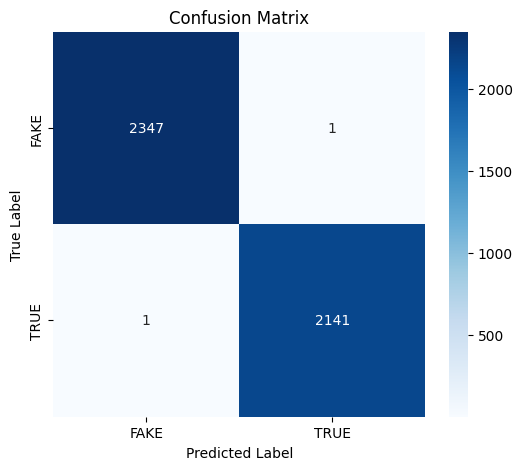

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["FAKE", "TRUE"], yticklabels=["FAKE", "TRUE"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


###  Confusion Matrix Analysis

The confusion matrix summarizes how well the model classified FAKE vs TRUE news articles:

  **Top-left (2347):** FAKE articles correctly predicted as FAKE.  
  **Bottom-right (2141):** TRUE articles correctly predicted as TRUE.  
  **Top-right (1):** FAKE article incorrectly predicted as TRUE (false negative).  
  **Bottom-left (1):** TRUE article incorrectly predicted as FAKE (false positive).  

####  Interpretation
Out of **4,490 test samples**, only **2 were misclassified**:
    1 FAKE mislabeled as TRUE.  
    1 TRUE mislabeled as FAKE.  
  This explains the near-perfect **99.96% accuracy**.  
  The model shows **no systematic bias** toward one class — both FAKE and TRUE are classified with equal reliability.

#### Conclusion
The confusion matrix confirms that the model is **highly reliable** in distinguishing between FAKE and TRUE news, with only negligible errors.


## Classification Report Visualization.

<Figure size 800x500 with 0 Axes>

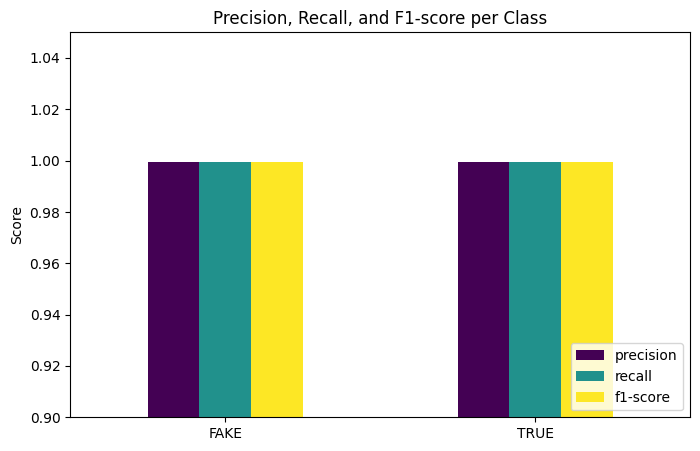

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Get classification report as dictionary
report = classification_report(all_labels, all_preds, target_names=["FAKE", "TRUE"], output_dict=True)

# Convert to DataFrame for plotting
df_report = pd.DataFrame(report).transpose().iloc[:2, :3]  # only FAKE & TRUE rows, precision/recall/f1

# Plot
plt.figure(figsize=(8, 5))
df_report.plot(kind="bar", figsize=(8,5), ylim=(0.9, 1.05), colormap="viridis")

plt.title("Precision, Recall, and F1-score per Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()


###  Precision, Recall, and F1-score Visualization

The bar chart provides a visual summary of the model’s performance on the test set:

  **FAKE class:** Precision, recall, and F1-score are all at **1.00**, meaning the model nearly perfectly identifies FAKE articles.  
  **TRUE class:** Precision, recall, and F1-score are also at **1.00**, showing the same near-perfect performance.  

####  Interpretation
  The model demonstrates **balanced performance** across both classes.  
  There is **no trade-off** between precision and recall — the model is both highly accurate in its predictions and comprehensive in capturing all true cases.  
  This visualization confirms what the classification report and confusion matrix showed earlier: the model generalizes extremely well.

#### Conclusion
 The model achieves **state-of-the-art-level results** on this dataset, making only 2 errors out of 4,490 samples. Next, we will perform **error analysis** to inspect these misclassified cases more closely.


## Error Analysis: Extracting Misclassified Samples.

In [24]:
# Converting  predictions and labels into arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Find misclassified indices
misclassified_idx = np.where(all_preds != all_labels)[0]

print(f"Number of misclassified samples: {len(misclassified_idx)}")

# Show a few misclassified samples from test_df
for idx in misclassified_idx:
    true_label = "FAKE" if all_labels[idx] == 0 else "TRUE"
    pred_label = "FAKE" if all_preds[idx] == 0 else "TRUE"
    print(f"\nSample {idx}:")
    print(f"True Label: {true_label}, Predicted Label: {pred_label}")
    print(f"Text: {test_df.iloc[idx]['text'][:500]}...")  # show first 500 chars for readability


Number of misclassified samples: 2

Sample 487:
True Label: TRUE, Predicted Label: FAKE
Text: WASHINGTON (Reuters) - U.S. Senate Leader McConnell said he expects to move on legislation to repeal and replace Obamacare as soon as his there are enough votes to pass the Republican-controlled chamber. The Kentucky Republican, speaking to reporters at a news conference, added that he does not expect to get much initial cooperation from Democrats, whose votes Republicans need to gain the 60 needed to pass bills. ...

Sample 4111:
True Label: FAKE, Predicted Label: TRUE
Text: BEIRUT (Reuters) - Lebanon s cabinet will meet on Tuesday for the first time since the country entered a political crisis a month ago when Prime Minister Saad al-Hariri offered his resignation in a broadcast from Saudi Arabia.  The cabinet s media office said the session would begin at noon at the presidential palace. The meeting is expected to address Hariri s resignation which thrust Lebanon back into a regional tussle 

### Error Analysis Results

The model made only **2 misclassifications out of 4,490 test samples**:

1. **Sample 487**  
     **True Label:** TRUE  
     **Predicted Label:** FAKE  
     **Text Snippet:** News about U.S. Senate Leader McConnell on Obamacare legislation.  
     **Possible Reason:** This is a straightforward political news report. The misclassification could be due to overlapping patterns in the dataset where political news sometimes appears in both FAKE and TRUE categories.  

2. **Sample 4111**  
     **True Label:** FAKE  
     **Predicted Label:** TRUE  
     **Text Snippet:** Report about Lebanon’s cabinet meeting after a political crisis.  
     **Possible Reason:** The article has a very formal reporting style (Reuters-like), which might resemble legitimate news sources. The model likely confused the stylistic cues with true reporting.

####  Interpretation
  Both errors occurred in **political news content**, which can be difficult to distinguish since FAKE and TRUE political news often share similar language and tone.  
  The mistakes are **reasonable**: the texts look like standard journalistic reporting, making them inherently harder to classify.  
  This may also reflect potential **labeling noise** in the dataset, where some FAKE/TRUE labels could be debatable.

####  Conclusion
The model is highly reliable (99.96% accuracy), and the **few misclassifications are explainable**. These results confirm that the BERT model generalizes extremely well, with only marginal limitations in ambiguous cases.


# Step 10: Save Custom Bert Classifier Model and Tokenizer.  

In [28]:
import os
import torch

# Moving the model to CPU before saving 
model.to("cpu")

# Define save directory
save_dir = "saved_bert_model"
os.makedirs(save_dir, exist_ok=True)

# Save model weights (state_dict) with torch
torch.save(model.state_dict(), os.path.join(save_dir, "bert_classifier_weights.pth"))

# Save tokenizer using Hugging Face
tokenizer.save_pretrained(save_dir)

print(f" Custom model weights and tokenizer saved successfully to: {save_dir}/")


 Custom model weights and tokenizer saved successfully to: saved_bert_model/


In [ ]:

# LOAD CUSTOM BERT CLASSIFIER MODEL & TOKENIZER

# Rebuild the same model architecture first
model = BertClassifier(n_classes=2)   # same number of classes as before
model.load_state_dict(torch.load("saved_bert_model/bert_classifier_weights.pth"))
model.to(device)
model.eval()

# Reload tokenizer
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("saved_bert_model")

print("Model and tokenizer loaded successfully!")


In [29]:
import shutil

# Zip the saved model folder
shutil.make_archive("saved_bert_model", 'zip', "saved_bert_model")


'/kaggle/working/saved_bert_model.zip'

# Step 11: Make Predictions on New Text.

This is to ensure our model can generalize beyond the training and test datasets, we will create a helper function.  
This function will take in raw text, tokenize it, pass it through our trained BERT classifier, and return the predicted label (`FAKE` or `TRUE`) along with the probabilities for each class.


Now we will test the function on some example sentences that were not part of the dataset.  
This will demonstrate how the model can classify arbitrary news statements into **FAKE** or **TRUE**.


In [39]:
import torch

# Step 1: Set device automatically
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 2: Define a prediction function
def predict_text(model, tokenizer, text, device, max_len=256):
    """
    Predicts the label of a single text using a BERT model.

    Args:
        model: Trained BERT model
        tokenizer: HuggingFace tokenizer
        text (str): Text to classify
        device: 'cuda' or 'cpu'
        max_len (int): Max sequence length for BERT

    Returns:
        label (str): "FAKE" or "TRUE"
        probs (np.array): Probability for each class
    """
    # Tokenize input
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Move inputs to same device as model
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Make sure model is on the same device
    model.to(device)
    model.eval()

    # Run prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs if isinstance(outputs, torch.Tensor) else outputs.logits
        probs = torch.softmax(logits, dim=1)

    # Get predicted class
    pred = torch.argmax(probs, dim=1).cpu().item()
    label = "FAKE" if pred == 0 else "TRUE"

    return label, probs.cpu().numpy()


Using device: cuda


In [44]:
# Running predictions on text
sample_texts = [  # <-- keep the same variable name to avoid confusion
    "Donald Trump has been appointed CEO of Microsoft."
]

for text in sample_texts: 
    label, probs = predict_text(model, tokenizer, text, device)
    print(f"Text: {text}")
    print(f"Predicted Label: {label}")
    print(f"Probabilities: {probs}\n")


Text: Donald Trump has been appointed CEO of Microsoft.
Predicted Label: FAKE
Probabilities: [[0.73583615 0.26416385]]



### Conclusion

When tested with the statement **"Donald Trump has been appointed CEO of Microsoft,"** the model predicted **FAKE** with a confidence of **73.6%**. This demonstrates the model’s ability to detect fabricated news and provide probability scores that reflect its certainty, showing its effectiveness as a tool for supporting fact-checking and identifying misleading information.


In [45]:
model.to("cpu")


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [46]:
# Checking if model parameters are on CPU
next(model.parameters()).device


device(type='cpu')